In [21]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.losses import MeanSquaredError

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
img_size = (64,64,3)
embedding_dim = 512
filters = [32, 64, 96, 128]
T = 500
a = np.linspace(0.00001, 0.02, T)
embedding_max_frequency = tf.constant(1000.0, dtype=tf.float32)

In [23]:
def normalise_img(img_tensor): # Maps [-1,1] to [0,1]
    img = img_tensor.copy()
    img *= 0.5
    img += 0.5
    return img

def expand_img(img_tensor): # Maps [0,1] to [-1,1]
    img = img_tensor.copy()
    img *= 2
    img -= 1
    return img

def noisify_img(img_tensor, t): # Returns Epsilon, X_t (in [-1,1] form)
    epsilon = np.random.normal(0, 0.3, img_tensor.shape)
    img = img_tensor.copy()
    img = ((1 - a[t])**0.5) * img + (a[t]**0.5) * epsilon
    return img, epsilon

def denoisify_img(img_tensor, epsilon, t): # X_t-1 (in [-1,1] form)
    img = img_tensor.copy()
    img = (img - (epsilon * (a[t])**0.5)) / (1 - a[t])**0.5
    return img

def sinusoidal_embedding(x, embedding_dim=embedding_dim):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dim // 2,
        )
    )
    angular_speeds = tf.cast(2.0 * np.pi * frequencies, "float32")

    x = tf.reshape(x, (-1, 1, 1, 1))

    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=-1
    )
    return embeddings

def ResidualBlock(filters):
    def call(x):
        if filters == x.shape[3]:
            resid = x
        else:
            resid = Conv2D(filters, kernel_size=1)(x)
        x = BatchNormalization(center=False, scale=False)(x)
        x = Conv2D(filters, kernel_size=3, padding="same", activation="swish")(x)
        x = Conv2D(filters, kernel_size=3, padding="same")(x)
        x = Add()([x, resid])
        return x
    return call

def DownBlock(filters, depth):
    def call(x):
        x, cache = x
        for _ in range(depth):
            x = ResidualBlock(filters)(x)
            cache.append(x)
        x = AveragePooling2D(pool_size=2)(x)
        return x
    return call

def UpBlock(filters, depth):
    def call(x):
        x,cache = x
        x = UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(depth):
            x = Concatenate()([x, cache.pop()])
            x = ResidualBlock(filters)(x)
        return x
    return call

In [24]:
custom_objects = {
    "sinusoidal_embedding": sinusoidal_embedding,
    "mse": MeanSquaredError()
}

model = load_model('/content/drive/MyDrive/lexnet_v1.h5', custom_objects=custom_objects)

In [ ]:
imgs = []
for i in range(20):
  noise = np.random.normal(0, 0.3, (64,64,3))
  img = noise.copy()
  for i in range(1,T):
    t = T-i
    t_input = np.full((1, 1, 1), a[t] / (1 - a[t]), dtype=np.float32)
    epsilon = model.predict([np.array([img]), np.array([t_input])],verbose=0)[0]
    img = denoisify_img(img, epsilon, t)
    imgs.append(img)

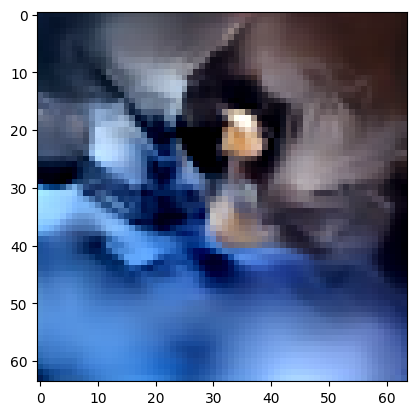

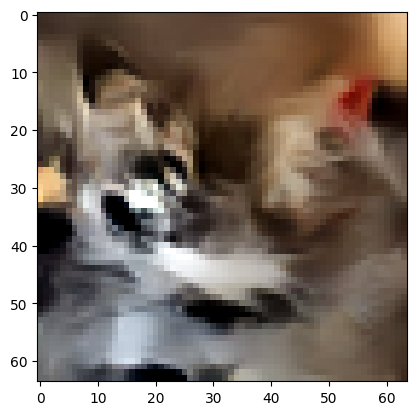

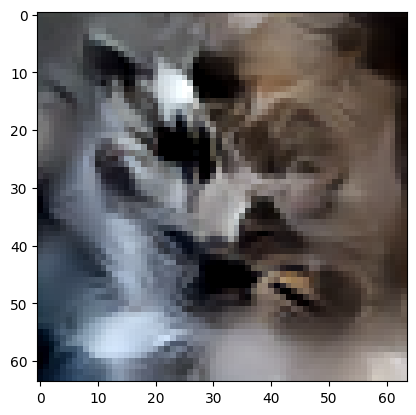

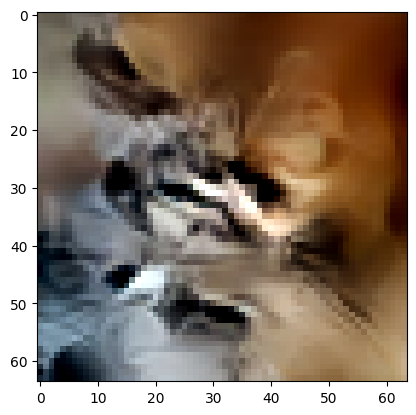

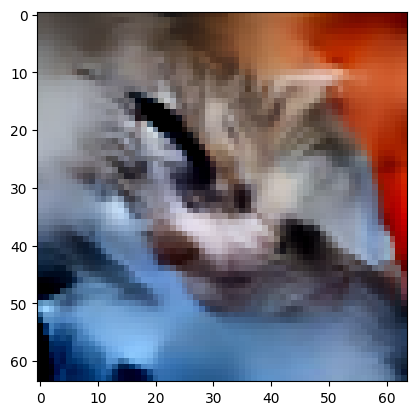

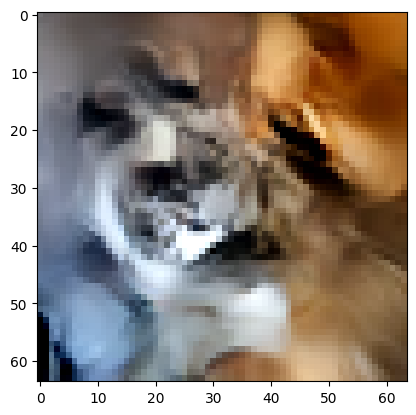

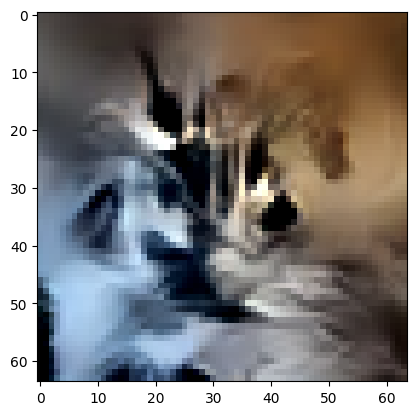

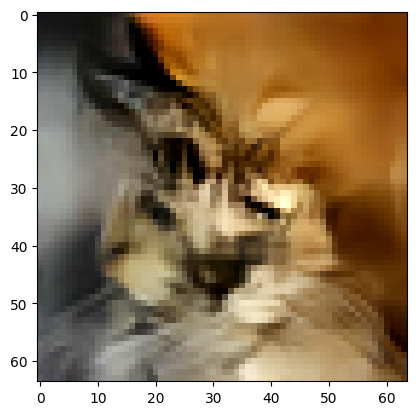

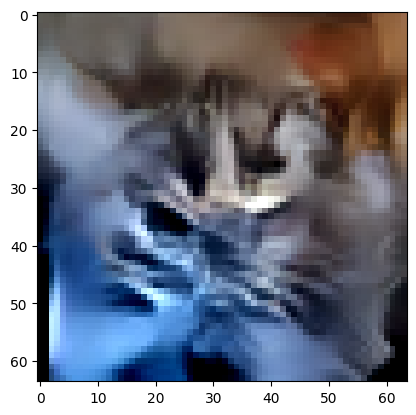

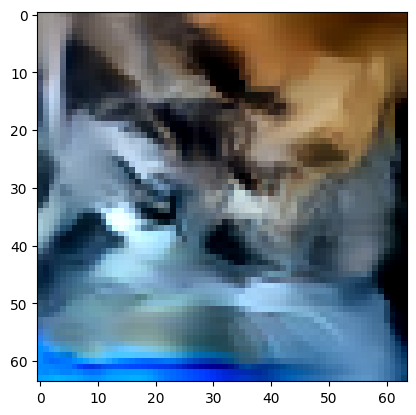

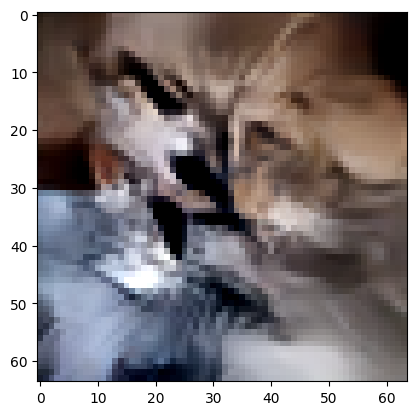

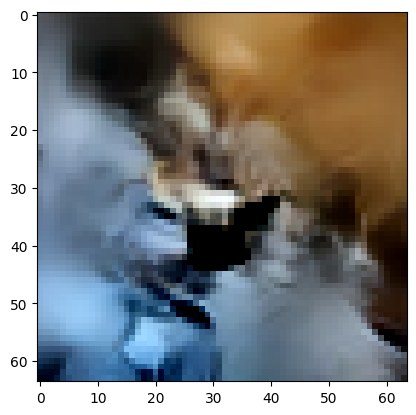

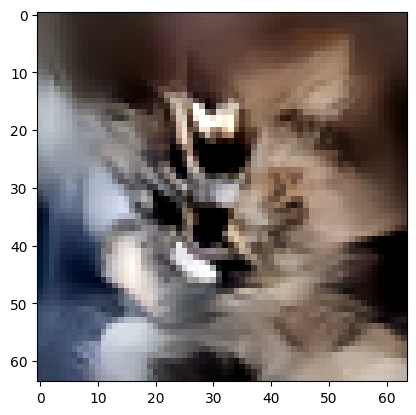

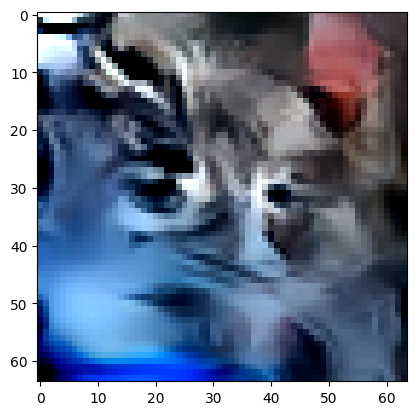

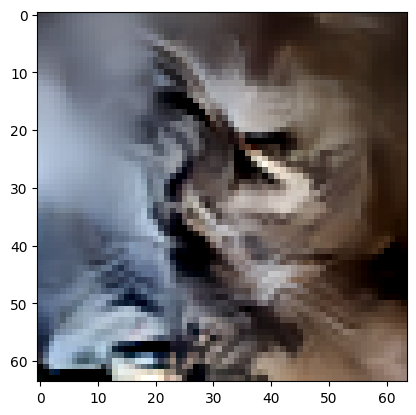

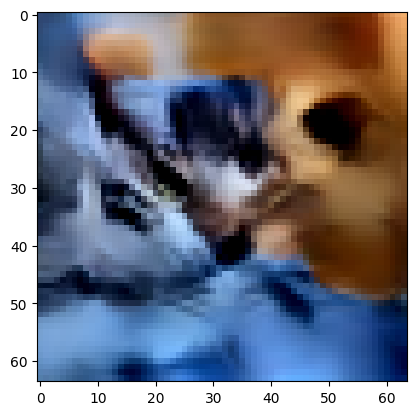

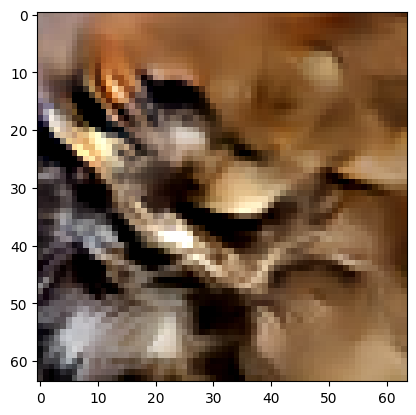

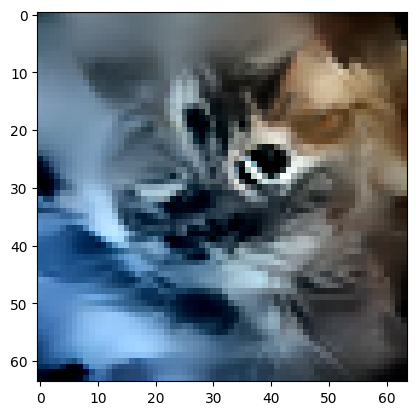

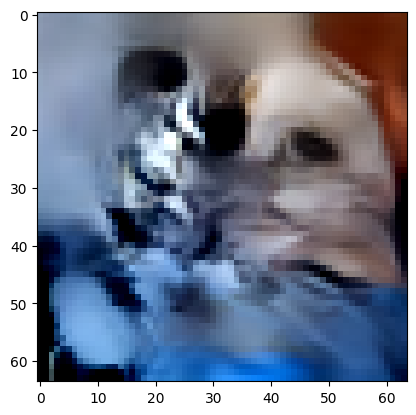

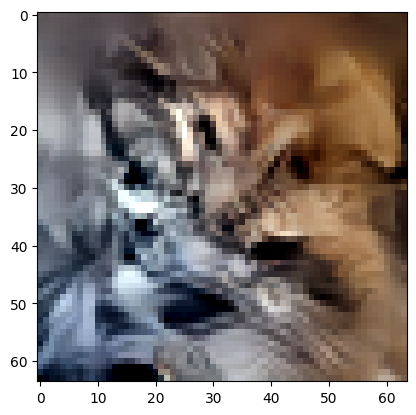

In [ ]:
for i in range(0,20):
  plt.imshow(normalise_img(imgs[(T-1)*i-1]))
  plt.show()